Import the libraries and data

In [26]:
#Import Libraries
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import scipy.io as scio
import pandas as pd
import re
from IPython.display import display, Image
import cv2

import warnings
warnings.filterwarnings("ignore")

In [29]:
#Import image files
train_image_files = os.listdir("train")
train_image_files = train_image_files[1:-7]
for image in train_image_files:
    image_file = image
    train_dataset = ndimage.imread(os.path.join("train", image)).astype(float)
train_labels = pd.read_csv('train/digitStruct_train.csv')

test_image_files = os.listdir("test")
test_image_files = test_image_files[1:-7]
for image in test_image_files:
    image_file = image
    test_dataset = ndimage.imread(os.path.join("test", image)).astype(float)
test_labels = pd.read_csv('test/digitStruct_test.csv')

Crop the images according to bounding box data

In [30]:
num_labels = 10
def cropping_region(labels_initial, dir_name):    
    labels = labels_initial
    
    Left_Start = pd.Series(labels_initial.groupby(['FileName'])['Left'].min())
    Top_Start = pd.Series(labels_initial.groupby(['FileName'])['Top'].min()) 
    Top_End = pd.Series(labels_initial.groupby(['FileName'])['Height'].max()) + pd.Series(labels_initial.groupby(['FileName'])['Top'].max())
    Left_End = pd.Series(labels_initial.groupby(['FileName'])['Width'].sum()) + Left_Start
   
    return_frame = pd.concat([Left_Start, Top_Start, Left_End, Top_End],axis=1)
    return_frame.columns=['Left_Start','Top_Start','Left_End','Top_End']
    return return_frame

test_crop_data = cropping_region(test_labels, "test")
train_crop_data = cropping_region(train_labels, "train")

In [ ]:
def resize_image(image_name, dir_name, crop_data):
    try:
        #print("new image")
        print(image_name)
        image = cv2.imread(dir_name + "/" + image_name)

        row = crop_data[crop_data.index==image_name]

        height = int(row['Top_End']-row['Top_Start'])
        width = int(row['Left_End']-row['Left_Start'])
        #print("height= " + str(height))
        #print("width= " + str(width))

        cropped_pre_resized = image[row['Top_Start']:row['Top_End'], row['Left_Start']:row['Left_End']]
        cv2.imwrite(dir_name + "/cropped_pre_resize/" + image_name, cropped_pre_resized)
        #display(Image(filename=dir_name + "/cropped_pre_resize/" + image_name))

        if width > height:
            desired_height_increase = width - height
            desired_height_increase_lower = int(desired_height_increase)/2
            desired_height_increase_upper = desired_height_increase - int(desired_height_increase)/2
            target_end = int(row['Top_End'] + desired_height_increase_upper)
            target_start = int(row['Top_Start'] - desired_height_increase_lower)
            if((target_end > 0) & (target_start > 0)):
                row['Top_End'] = target_end
                row['Top_Start'] = target_start
            cropped = image[row['Top_Start']:row['Top_End'], row['Left_Start']:row['Left_End']]
        elif width < height:
            desired_width_increase = height - width
            desired_width_increase_lower = int(desired_width_increase)/2
            desired_width_increase_upper = desired_width_increase - int(desired_width_increase)/2
            target_end = int(row['Left_End'] + desired_width_increase_upper)
            target_start = int(row['Left_Start'] - desired_width_increase_lower)
            if((target_end > 0) & (target_start > 0)):
                row['Left_End'] = target_end
                row['Left_Start'] = target_start
            #print(row['Left_End']-row['Left_Start'])
            #print("width less than height")
            cropped = image[row['Top_Start']:row['Top_End'], row['Left_Start']:row['Left_End']]
        else:
            cropped = image

        #print(cropped.shape)
        cropped = cv2.resize(cropped, (32, 32), interpolation = cv2.INTER_AREA)
        cv2.imwrite(dir_name + "/cropped/" + image_name, cropped)
        #display(Image(filename=dir_name + "/" + image_name))
        #display(Image(filename=dir_name + "/cropped/" + image_name))
    except:
        print("exception")
        pass
    
image_files = os.listdir("test")
image_files = image_files[1:-3]
for image_name in image_files:
    resize_image(image_name, "test", test_crop_data)

image_files = os.listdir("train")
image_files = image_files[1:-3]
for image_name in image_files:
    resize_image(image_name, "train", train_crop_data)

1.png
10.png
100.png
1000.png
10000.png
10001.png
10002.png
10003.png
10004.png
10005.png
10006.png
10007.png
10008.png
10009.png
1001.png
10010.png
10011.png
10012.png
10013.png
10014.png
10015.png
10016.png
10017.png
10018.png
10019.png
1002.png
10020.png
10021.png
10022.png
10023.png
10024.png
10025.png
10026.png
10027.png
10028.png
10029.png
1003.png
10030.png
10031.png
10032.png
10033.png
10034.png
10035.png
10036.png
10037.png
10038.png
10039.png
1004.png
10040.png
10041.png
10042.png
10043.png
10044.png
10045.png
10046.png
10047.png
10048.png
10049.png
1005.png
10050.png
10051.png
10052.png
10053.png
10054.png
10055.png
10056.png
10057.png
10058.png
10059.png
1006.png
10060.png
10061.png
10062.png
10063.png
10064.png
10065.png
10066.png
10067.png
10068.png
10069.png
1007.png
10070.png
10071.png
10072.png
10073.png
10074.png
10075.png
10076.png
10077.png
10078.png
10079.png
1008.png
10080.png
10081.png
10082.png
10083.png
10084.png
10085.png
10086.png
10087.png
10088.png
10089.pn

Format the labels into one-hot encoding

In [31]:
#Set the number of digits per image, and number of labels per digit (obviously 10, from 0 to 9)
num_digits = 5
num_labels = 10
pixel_depth = 255

In [32]:
#Reformat_labels takes the bounding box data and converts it to vectors of length 55 for every image: 10 for the first
#image's class, 10 for the 2nd image's class (if any), up to 10 for the 5th image's class (if any), and then another
#5 elements for the length of the image.

def reformat_labels(labels_initial):    
    labels = labels_initial
    
    labels['DigitLabel'][labels['DigitLabel']==10] = 0
    one_hot = pd.DataFrame((np.arange(num_labels) == labels['DigitLabel'][:,None]).astype(np.float32))
    g = labels
    g_index = pd.Series(g.index)
    g = g.sort(['FileName']).groupby('FileName')
    labels['DigitLabelIndex'] = g_index.rank(method='first', na_option='top')
    labels['ImageNumber'] = pd.Series([int(labels['FileName'][i].split('.')[0]) for i in range(labels['FileName'].shape[0])])
    labels['NumberIndex'] = pd.Series(labels.groupby('ImageNumber')['DigitLabelIndex'].rank(ascending=True))
    labels = pd.concat([labels,one_hot],axis=1)

    labels.index = labels_initial['ImageNumber']
    
    labels_1 = labels[labels['NumberIndex']==1]
    labels_2 = labels[labels['NumberIndex']==2]
    labels_3 = labels[labels['NumberIndex']==3]
    labels_4 = labels[labels['NumberIndex']==4]
    labels_5 = labels[labels['NumberIndex']==5]

    labels_ref = labels_1.ix[:,9:]
    labels_ref = labels_ref.merge(labels_2.ix[:,9:],'left',left_index=True,right_index=True)
    labels_ref = labels_ref.merge(labels_3.ix[:,9:],'left',left_index=True,right_index=True)
    labels_ref = labels_ref.merge(labels_4.ix[:,9:],'left',left_index=True,right_index=True)
    labels_ref = labels_ref.merge(labels_5.ix[:,9:],'left',left_index=True,right_index=True)
    
    test_num_digits = labels_ref.sum(axis=1)
    one_hot_L = pd.DataFrame((np.arange(num_digits+1)[1:] == test_num_digits[:,None]).astype(np.float32),index=labels_ref.index)
    labels_ref = labels_ref.merge(one_hot_L,'left',left_index=True,right_index=True)
   
    return labels_ref

test_labels = reformat_labels(test_labels)
train_labels = reformat_labels(train_labels)

Test a sample image to make sure the label is correct

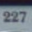

Empty DataFrame
Columns: [0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 0_y, 1_y, 2_y, 3_y, 4_y, 5_y, 6_y, 7_y, 8_y, 9_y, 0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 0_y, 1_y, 2_y, 3_y, 4_y, 5_y, 6_y, 7_y, 8_y, 9_y, 0_x, 1_x, 2_x, 3_x, 4_x, 5, 6, 7, 8, 9, 0_y, 1_y, 2_y, 3_y, 4_y]
Index: []

[0 rows x 55 columns]
(32, 32)


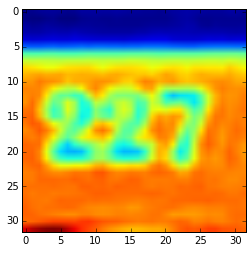

In [52]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""
    
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_GCN

display(Image(filename="test/cropped/13067.png"))
print(test_labels[13066:13067])
image_data_cv2 = (ndimage.imread("test/cropped/13067.png",flatten=True))
#image_data_cv2 = np.dot(image_data_cv2, [[0.2989],[0.5870],[0.1140]])
#image_data_cv2 = ndimage.imread("test/cropped/13067.png")
print(image_data_cv2.shape)

%matplotlib inline
plt.imshow(image_data_cv2)

Convert cropped images to arrays and store in np.ndarray

In [34]:
#Remove any labels for images that could not be cropped

train_to_keep = pd.Series()
test_to_keep = pd.Series()

for image in os.listdir("train/cropped"):
    image_file = os.path.join("train/cropped", image)
    train_to_keep = train_to_keep.append(pd.Series(int(image_file.split("/")[2].split(".")[0])))
    
for image in os.listdir("test/cropped"):
    image_file = os.path.join("test/cropped", image)
    test_to_keep = test_to_keep.append(pd.Series(int(image_file.split("/")[2].split(".")[0])))
    
train_labels = train_labels[train_labels.index.isin(train_to_keep)]
test_labels = test_labels[test_labels.index.isin(test_to_keep)]

In [48]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
image_col = 1 #rgb

def load_images(folder, min_num_images, data_labels):
  """Load the data for a single letter label."""
  #output_labels = pd.DataFrame()
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  #image_index = 0
  print(folder)
  for image in os.listdir(folder):
    image_file = os.path.join(folder, image)
    image_index = int(image_file.split("/")[2].split(".")[0])
    label_loc = (data_labels.index==image_index).argmax()
    #print("image: " + str(image_file) + " " + str(image_index))
    #print("label index: " + str(label_loc))
    ##print(image_index)
    if(image_index in data_labels.index):
        #print(image)
        #print(image_index)
        #print("")
        try:
          image_data = (ndimage.imread(image_file,flatten=True))

          image_data_cv2 = cv2.imread(image_file)
          #print(image_data_cv2.shape)
          #print(image_data.shape)
          #print(image_data[:5])
          if image_data.shape != (image_size, image_size):
            raise Exception('Unexpected image shape: %s' % str(image_data.shape))
          dataset[label_loc, :] = image_data
        
          if(label_loc==23394):
              print("Image Data:")
              print(image_data)
             
              print("Image Data 2:")
              print(((ndimage.imread("train/cropped/23411.png").astype(float) - pixel_depth / 2) / pixel_depth))
            
              print("Image Data 3:")
              print(dataset[label_loc, :, :])
            
          #image_index += 1
        except IOError as e:
          print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  #num_images = image_index
  num_images = len(os.listdir(folder))
  dataset = dataset[0:num_images, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, data_labels, p_name, force=False):
  set_filename = p_name + '.pickle'
  print('Pickling %s.' % data_folders)
  dataset = load_images(data_folders, min_num_images_per_class, data_labels)
  print("Pickling Stage")
  print(dataset.shape)
  try:
    with open(set_filename, 'wb') as f:
      pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
  except Exception as e:
    print('Unable to save data to', set_filename, ':', e)
  return dataset
  
  #return dataset_names

train_dataset = maybe_pickle("train/cropped", 0, train_labels, "train_dataset")
test_dataset = maybe_pickle("test/cropped", 0, test_labels, "test_dataset")

Pickling train/cropped.
train/cropped
Image Data:
[[ 35.09000015  40.09000015  44.20399857 ...,  78.75900269  72.28600311
   66.81300354]
 [ 36.31800079  40.73099899  45.31800079 ...,  79.94400024  69.28600311
   65.81300354]
 [ 36.73099899  41.84500122  45.84500122 ...,  79.71600342  67.17199707
   65.10099792]
 ..., 
 [ 46.2859993   53.05799866  52.83000183 ...,  63.83000183  61.05799866
   61.17200089]
 [ 45.17200089  52.17200089  51.24300003 ...,  64.94400024  62.05799866
   62.05799866]
 [ 44.05799866  51.05799866  49.94400024 ...,  66.94400024  61.05799866
   62.05799866]]
Image Data 2:
[[[-0.39019608 -0.35882353 -0.30784314]
  [-0.37058824 -0.33921569 -0.28823529]
  [-0.35490196 -0.32352941 -0.26862745]
  ..., 
  [-0.20980392 -0.19019608 -0.14705882]
  [-0.23333333 -0.21764706 -0.16666667]
  [-0.25294118 -0.24117647 -0.18235294]]

 [[-0.38627451 -0.35490196 -0.29607843]
  [-0.36666667 -0.33921569 -0.27647059]
  [-0.35098039 -0.31960784 -0.26078431]
  ..., 
  [-0.20196078 -0.1862

In [53]:
train_dataset = GCN(train_dataset)
test_dataset = GCN(test_dataset)

Pickle the data

In [54]:
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [49]:
train_dataset.shape

(33373, 32, 32)

Make sure training/testing data lines up with labels

[  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan   0.   1.   0.   0.   0.]
8006


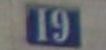

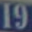

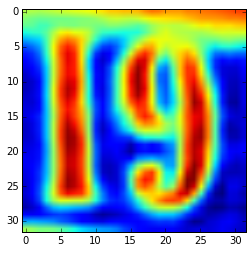

In [55]:
%matplotlib inline

index_to_test = 8000

plt.imshow(train_dataset[index_to_test])

print(train_labels.values[index_to_test])

print(train_labels.index[index_to_test])

train_label_filename_cropped = "train/cropped/" + str(train_labels.index[index_to_test]) + ".png"
train_label_filename = "train/" + str(train_labels.index[index_to_test]) + ".png"
display(Image(filename=train_label_filename))
display(Image(filename=train_label_filename_cropped))

[  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
   0.   0.   0.   0.   0.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan   0.   1.   0.   0.   0.]
8007


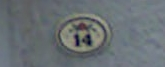

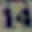

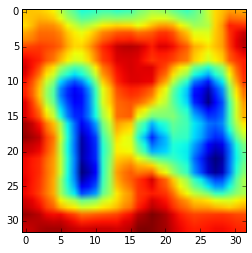

In [56]:
%matplotlib inline
plt.imshow(test_dataset[index_to_test])

print(test_labels.values[index_to_test])

print(test_labels.index[index_to_test])

test_label_filename_cropped = "test/cropped/" + str(test_labels.index[index_to_test]) + ".png"
test_label_filename = "test/" + str(test_labels.index[index_to_test]) + ".png"
display(Image(filename=test_label_filename))
display(Image(filename=test_label_filename_cropped))